# Titanic Survival Predictions 

The Objective of this competition was to predict whether passengers aboard the Titanic survived or not based on a set of features

In [1]:
# Load Required Libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# Load Data
train_df = pd.read_csv("titanic_train.csv")
test_df = pd.read_csv("titanic_test.csv")

In [3]:
# View features
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# High Level view of data 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
women = train_df.loc[train_df.Sex == 'female']["Survived"]
men = train_df.loc[train_df.Sex == 'male']["Survived"]
print("% of women who survived:", (sum(women)/len(women))*100)
print("% of men who survived:", (sum(men)/len(men))*100)
print(len(train_df.loc[train_df.Survived == 1]))
print(len(train_df.loc[train_df.Survived == 0]))

% of women who survived: 74.20382165605095
% of men who survived: 18.890814558058924
342
549


### Visualiation of Age Distribution by Passenger Class

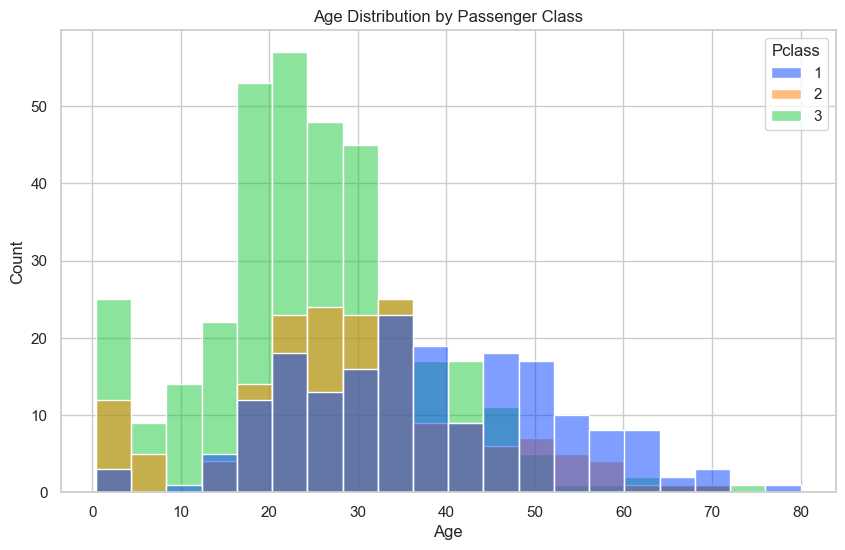

In [7]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.histplot(data=train_df, x="Age", hue="Pclass", kde=False, palette="bright")
plt.title("Age Distribution by Passenger Class")

plt.show()

### Feature Engineering
1. Names will be dropped but would be interesting to keep titles (rare titles may correspond to higher survivial)
2. No need to have siblings and parents in two seperate features -> Combine these
3. Letter in Cabin is more informative about level on the ship
4. Use the first part of the ticket number

In [8]:
# Extract Title from Name using Regex
train_df["Title"] = train_df["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
test_df["Title"] = test_df["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)

In [9]:
# Replace titles 'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona' with Rare
test_df["Title"].unique(), train_df["Title"].unique()

(array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
       dtype=object),
 array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
        'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
        'Jonkheer'], dtype=object))

In [10]:
# Simplify Rare titles
for df in [train_df, test_df]:
    df["Title"] = df["Title"].replace(
        ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev',
         'Sir', 'Jonkheer', 'Dona'], 'Rare'
    )
    df["Title"] = df["Title"].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

# Combine SibSp + Parch → FamilySize
for df in [train_df, test_df]:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

# Extract Cabin Letter
for df in [train_df, test_df]:
    df["CabinLetter"] = df["Cabin"].fillna('U').str[0]

# Extract Ticket Prefix
for df in [train_df, test_df]:
    df["TicketPrefix"] = df["Ticket"].apply(lambda x: x.split()[0] if not x.split()[0].isdigit() else 'None')

### Handle Missing Values

In [11]:
# Fill Embarked with mode as only two values missing
for df in [train_df, test_df]:
    df["Embarked"].fillna(train_df["Embarked"].mode()[0], inplace=True)

# Fill missing Fare in test set with median of same Pclass
test_df["Fare"].fillna(test_df.groupby("Pclass")["Fare"].transform("median"), inplace=True)

# Group-based imputation for Age (by Sex & Pclass) as 20% of Age values missing - too many to drop
for df in [train_df, test_df]:
    df["Age"] = df.groupby(["Pclass"])["Age"].transform(lambda x: x.fillna(x.median()))

/var/folders/fk/ln6xbd8n2dq25_4_pkjxwjyw0000gn/T/ipykernel_41674/2742534617.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Embarked"].fillna(train_df["Embarked"].mode()[0], inplace=True)
/var/folders/fk/ln6xbd8n2dq25_4_pkjxwjyw0000gn/T/ipykernel_41674/2742534617.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

In [12]:
# Drop Redundant Features
drop_cols = ["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch"]
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

### Create the Model and fit

In [13]:
# Split Features/Target
X = train_df.drop("Survived", axis=1)
y = train_df["Survived"]

# Define Feature Types
categorical_features = ["Sex", "Embarked", "Title", "CabinLetter", "TicketPrefix"]
numeric_features = ["Age", "Fare", "Pclass", "FamilySize"]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

# Define Base Learners
base_model = [
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42)),
    ("gb", GradientBoostingClassifier(n_estimators=200, random_state=42)),
    ("svc", SVC(probability=True, random_state=42))
]

# Define Stacking Classifier
stacking_model = StackingClassifier(
    estimators=base_model,
    final_estimator=LogisticRegression(max_iter=10000),
    cv=5
)

# Build Full Pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),     # encodes categorical features
    ("model", stacking_model)
])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train Model
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluate Model and Generate Predictions for Test Data

In [14]:
# Evaluate
y_hat = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_hat))
print("Precision:", precision_score(y_test, y_hat))
print("Recall:", recall_score(y_test, y_hat))
print("F1 Score:", f1_score(y_test, y_hat))

# Predict on Test Data
test_pred = model.predict(test_df)

# Save predictions with PassengerId
submission = pd.DataFrame({
    "PassengerId": pd.read_csv("titanic_test.csv")["PassengerId"],
    "Survived": test_pred})

submission.to_csv("titanic_submission.csv", index=False)

Accuracy: 0.8379888268156425
Precision: 0.8
Recall: 0.8108108108108109
F1 Score: 0.8053691275167785
